In [21]:
from MultiHead.MultiHeadAttention import MultiHeadAttentionFCN
from MultiHead.TransferLearning import TransferAttention

In [22]:
from tensorflow.keras.models import load_model

In [23]:
import pandas as pd
import numpy as np

In [24]:
model_one = load_model("models/model_one.keras", custom_objects={"MultiHeadAttentionFCN": MultiHeadAttentionFCN})
model_two = load_model("models/brfss_model.keras", custom_objects={"TransferAttention": TransferAttention})
model_three = load_model("models/Early_Diabetes_symptom.keras", custom_objects={"TransferAttention": TransferAttention})

d:\Lakehead\Semster2\Research Methology\Early Stage Diabetes\env\Lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 62 variables whereas the saved optimizer has 46 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [26]:
diabetes_prediction = pd.read_csv("data_source/diabetes_prediction_dataset.csv")

In [27]:
def process_smoking_habit(habit: str) -> str:
  if habit == "never" or habit == "ever":
    return "non-smoker"
  elif habit == "former" or habit == "current" or habit == "not current":
    return "smoker"
  elif habit == "No Info":
    return "unknown"

diabetes_prediction["smoking_history"] = diabetes_prediction["smoking_history"].apply(process_smoking_habit)

In [28]:
def categorical_age(age: int) -> int:
    age_ranges = [(18, 24), (25, 29), (30, 34), (35, 39), (40, 44),
                  (45, 49), (50, 54), (55, 59), (60, 64), (65, 69),
                  (70, 74), (75, 79), (80, float("inf"))]

    for idx, (start, end) in enumerate(age_ranges, start=1):
        if start <= age <= end:
            return idx
    return 0
diabetes_prediction["age"] = diabetes_prediction["age"].apply(categorical_age)

In [29]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
diabetes_prediction["gender"] = le.fit_transform(diabetes_prediction["gender"])
diabetes_prediction["smoking_history"] = le.fit_transform(diabetes_prediction["smoking_history"])

In [30]:
x1, y1 = diabetes_prediction.drop("diabetes", axis=1), diabetes_prediction["diabetes"]

In [31]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(random_state=42)

In [32]:
def sample_dataset(X, y):
  X_resampled, y_resampled = smote.fit_resample(X, y)
  return X_resampled, y_resampled

In [33]:
x1, y1 = sample_dataset(x1, y1)

In [34]:
from sklearn.preprocessing import StandardScaler
std = StandardScaler()
x1 = std.fit_transform(x1)

In [35]:
from sklearn.model_selection import train_test_split
X_train1, X_test1, y_train1, y_test1 = train_test_split(x1, y1, test_size=0.2, stratify=y1, random_state=42)

In [36]:
brfss = pd.read_csv("data_source/diabetes_binary_health_indicators_BRFSS2015.csv")
x2, y2 = brfss.drop("Diabetes_binary", axis=1), brfss["Diabetes_binary"]
x2, y2 = sample_dataset(x2, y2)
x2 = std.fit_transform(x2)
X_train2, X_test2, y_train2, y_test2 = train_test_split(x2, y2, test_size=0.2, stratify=y2, random_state=42)


In [37]:
symptom = pd.read_csv("data_source/diabetes_data_upload.csv")

In [38]:
symptom.iloc[100]

Age                         48
Gender                  Female
Polyuria                   Yes
Polydipsia                 Yes
sudden weight loss         Yes
weakness                    No
Polyphagia                 Yes
Genital thrush             Yes
visual blurring             No
Itching                     No
Irritability               Yes
delayed healing            Yes
partial paresis             No
muscle stiffness           Yes
Alopecia                   Yes
Obesity                    Yes
class                 Positive
Name: 100, dtype: object

In [42]:
symptom["class"] = symptom["class"].map({"Positive": 1, "Negative": 0})
symptom["Age"] = symptom["Age"].apply(categorical_age)
x3, y3 = symptom.drop("class", axis=1), symptom["class"]
for i in x3.columns:
    x3[i] = le.fit_transform(x3[i])
x3, y3 = sample_dataset(x3, y3)
x3 = std.fit_transform(x3)
X_train3, X_test3, y_train3, y_test3 = train_test_split(x3, y3, test_size=0.2, stratify=y3, random_state=42)

In [45]:
type(X_test3[0])

numpy.ndarray

In [50]:
import lime
import lime.lime_tabular

In [51]:
symptom.columns[:-1]

Index(['Age', 'Gender', 'Polyuria', 'Polydipsia', 'sudden weight loss',
       'weakness', 'Polyphagia', 'Genital thrush', 'visual blurring',
       'Itching', 'Irritability', 'delayed healing', 'partial paresis',
       'muscle stiffness', 'Alopecia', 'Obesity'],
      dtype='object')

In [52]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train3,
    mode="classification",
    feature_names=list(symptom.columns[:-1]),
    class_names=["Non-Diabetic", "Diabetic"],
    discretize_continuous=True
)

In [53]:
def predict_fn(X):
    preds = model_three.predict(X)
    preds = np.hstack([1 - preds, preds])
    return preds

In [55]:
sample_idx = 100
sample = X_test3[sample_idx].reshape(1, -1) 

explanation = explainer.explain_instance(
    b[0], 
    predict_fn,
    num_features=20 
)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [66]:
import matplotlib.pyplot as plt

In [69]:
explanation.show_in_notebook()

In [23]:
import shap

d:\Lakehead\Semster2\Research Methology\Early Stage Diabetes\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [24]:
explainer = shap.Explainer(model_one, X_train1[0:100])

In [25]:
shap_values = explainer(X_test1[0:100])

ExactExplainer explainer: 101it [01:06,  1.50it/s]                         


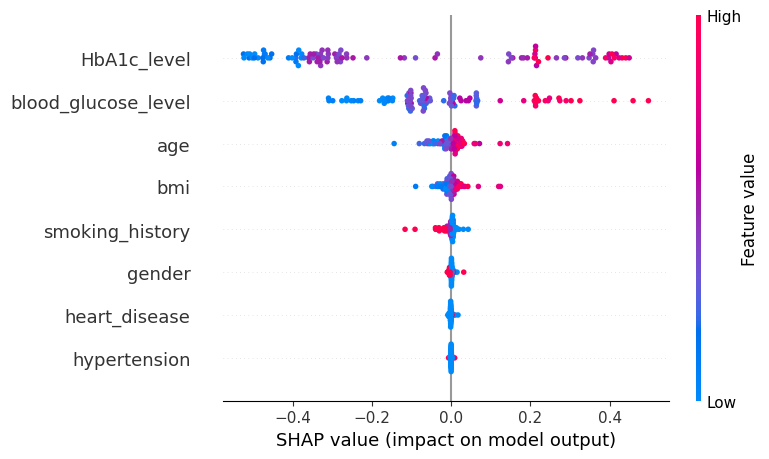

In [26]:
shap.summary_plot(shap_values, X_test1[0:100], feature_names=list(diabetes_prediction.columns[:-1]))

In [ ]:
explainer = shap.Explainer(model_two, X_train2[0: 100])

In [28]:
shap_values = explainer(X_test2[0:100])

PermutationExplainer explainer: 101it [01:01,  1.36it/s]                         


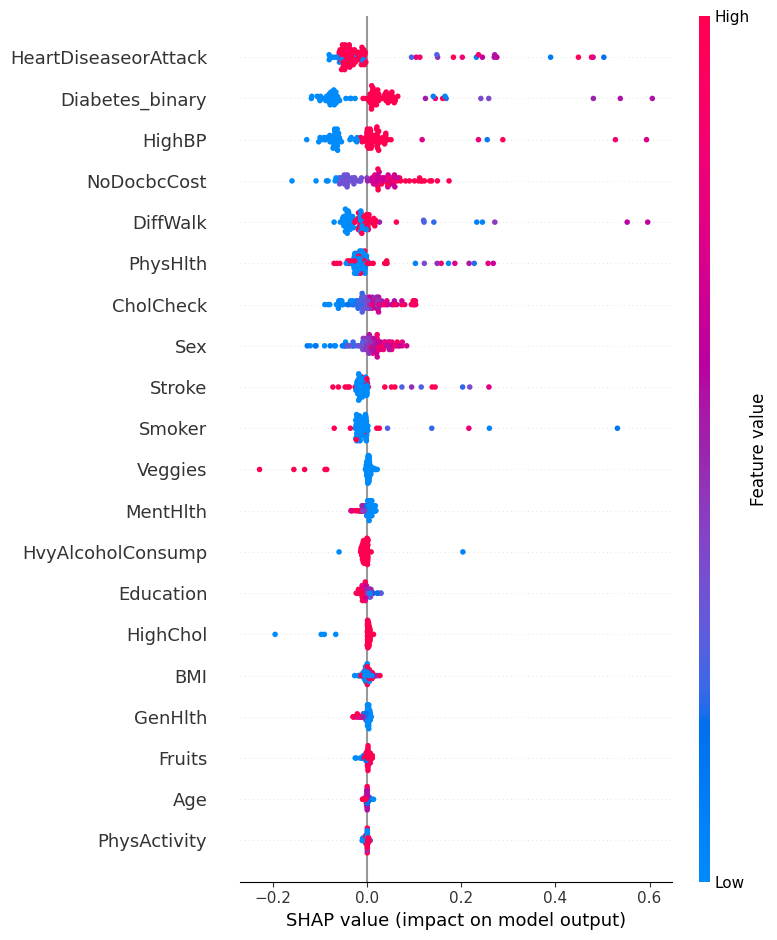

In [29]:
shap.summary_plot(shap_values, X_test2[0:100], feature_names=list(brfss.columns[:-1]))

In [30]:
explainer = shap.Explainer(model_three, X_train3[:])

In [31]:
shap_values = explainer(X_test3[:])

PermutationExplainer explainer: 129it [01:29,  1.27it/s]                         


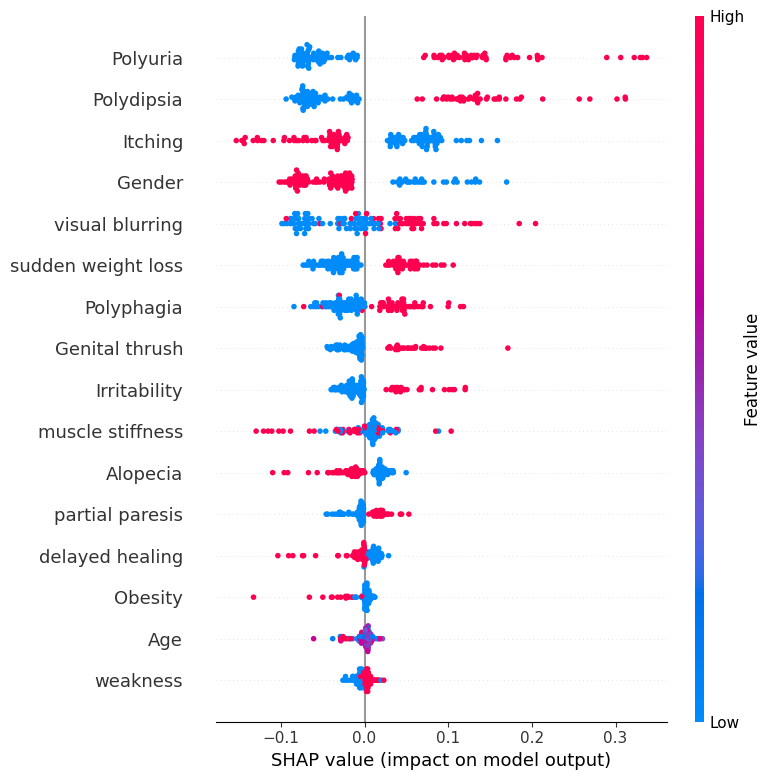

In [32]:
shap.summary_plot(shap_values, X_test3[:], feature_names=list(symptom.columns[:-1]))

In [61]:
from transformers import pipeline

d:\Lakehead\Semster2\Research Methology\Early Stage Diabetes\env\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [36]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["No Diabetes (0)", "Diabetes (1)"], 
                yticklabels=["No Diabetes (0)", "Diabetes (1)"])
    
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

In [37]:
y_pred = model_three.predict(X_test3)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


In [40]:
y_pred = (y_pred > 0.5).astype(int)

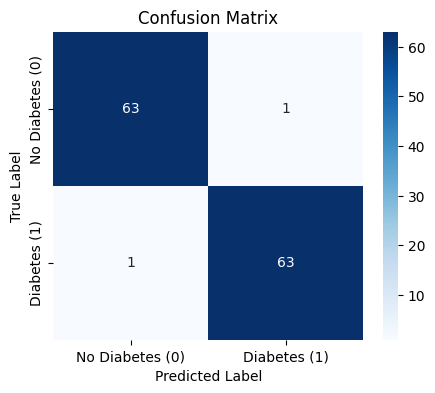

In [41]:
plot_confusion_matrix(y_test3, y_pred)

In [42]:
y_pred1 = model_one.predict(X_test1)

1144/1144 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [43]:
y_pred1 = (y_pred1 > 0.5).astype(int)

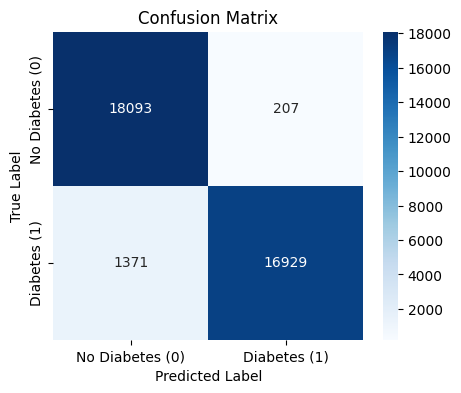

In [44]:
plot_confusion_matrix(y_test1, y_pred1)

In [45]:
y_pred2 = model_two.predict(X_test2)
y_pred2 = (y_pred2 > 0.5).astype(int)

2730/2730 ━━━━━━━━━━━━━━━━━━━━ 3s 971us/step


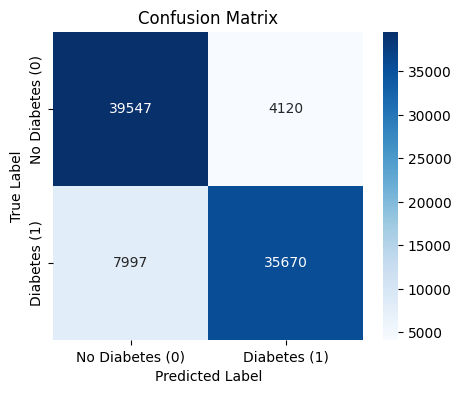

In [46]:
plot_confusion_matrix(y_test2, y_pred2)